# Exploratory Data Analysis of GDSC Dataset

### Overview of EDA
* Summary statistics to introduce dataset
* Evaluate correlations and how AUC is related to LN_IC50
* Univariate signals (drug-level, tissue-level)
* Check for confounding influence separately for IC50 and AUC, specifically:
    * dataset bias (GDSC1 vs GDSC2)
    * tissue bias (check broad - descriptor 1, and specific - descriptor 2)
    * growth medium bias
    * growth format bias
* Paired-endpoint concordance
* Divergence analysis of endpoints
    * Drilled down to per drug, per tissue descriptor level
* Light QC and censoring - flagged rows (5% of data) that were close to min/max drug concentrations and/or had poor RMSE

### Next steps
* Keep AUC raw ([0,1]) or bring AUC to comparable scale of LN_IC50 
* For parallel endpoint/ pareto analysis, keep same filtering/QC rules for AUC and LN_IC50. If endpoints are split, we can't remove 'poor fit' flags from LN_IC50 and not AUC
* Decide on tissue descriptor 1 or 2 to shape modeling
    *  If descriptor 2, may need to bootstrap/resample less abundant tissue types, or collapse rare classes
* Decide how to handle discordant endpoints; for most rows, LN_IC50 and AUC are in agreement (global pearson ~ 0.7) but they sometimes diverge

In [56]:
# Global library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

Load in the merged dataframe, containing GDSC1, GDSC2, and cell line metadata

In [58]:
gdsc_merged = pd.read_csv("GDSC1and2_w_CellLineData.csv")
print(gdsc_merged.shape)

(575197, 24)


## Overview and Summary Statistics

In [60]:
gdsc_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575197 entries, 0 to 575196
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DATASET                   575197 non-null  object 
 1   NLME_RESULT_ID            575197 non-null  int64  
 2   NLME_CURVE_ID             575197 non-null  int64  
 3   COSMIC_ID                 575197 non-null  int64  
 4   CELL_LINE_NAME            575197 non-null  object 
 5   SANGER_MODEL_ID           575197 non-null  object 
 6   TCGA_DESC                 573550 non-null  object 
 7   DRUG_ID                   575197 non-null  int64  
 8   DRUG_NAME                 575197 non-null  object 
 9   PUTATIVE_TARGET           544390 non-null  object 
 10  PATHWAY_NAME              575197 non-null  object 
 11  COMPANY_ID                575197 non-null  int64  
 12  MIN_CONC                  575197 non-null  float64
 13  MAX_CONC                  575197 non-null  f

In [61]:
gdsc_merged.head().T

,0,1,2,3,4
DATASET,GDSC1,GDSC1,GDSC1,GDSC1,GDSC1
NLME_RESULT_ID,342,342,342,342,342
NLME_CURVE_ID,15580432,15580806,15581198,15581542,15581930
COSMIC_ID,684057,684059,684062,684072,687448
CELL_LINE_NAME,ES5,ES7,EW-11,SK-ES-1,COLO-829
SANGER_MODEL_ID,SIDM00263,SIDM00269,SIDM00203,SIDM01111,SIDM00909
TCGA_DESC,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED,SKCM
DRUG_ID,1,1,1,1,1
DRUG_NAME,Erlotinib,Erlotinib,Erlotinib,Erlotinib,Erlotinib
PUTATIVE_TARGET,EGFR,EGFR,EGFR,EGFR,EGFR


In [62]:
gdsc_merged.describe(include=object).T

,count,unique,top,freq
DATASET,575197,2,GDSC1,333161
CELL_LINE_NAME,575197,978,MFM-223,684
SANGER_MODEL_ID,575197,978,SIDM00332,684
TCGA_DESC,573550,32,UNCLASSIFIED,108946
DRUG_NAME,575197,542,Selumetinib,3452
PUTATIVE_TARGET,544390,369,"MEK1, MEK2",10823
PATHWAY_NAME,575197,24,Other,63193
Sample Name,575197,978,MFM-223,684
GDSC_Tissue_descriptor_1,575197,19,lung_NSCLC,64499
GDSC_Tissue_descriptor_2,575197,55,lung_NSCLC_adenocarcinoma,38872


In [63]:
gdsc_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
NLME_RESULT_ID,575197.0,3.424208e+02,0.493686,3.420000e+02,3.420000e+02,3.420000e+02,3.430000e+02,3.430000e+02
NLME_CURVE_ID,575197.0,1.588175e+07,180714.705255,1.557976e+07,1.572361e+07,1.586747e+07,1.604516e+07,1.618978e+07
COSMIC_ID,575197.0,9.887166e+05,217936.181057,6.836670e+05,9.068000e+05,9.097170e+05,1.240140e+06,1.789883e+06
DRUG_ID,575197.0,1.090246e+03,631.362487,1.000000e+00,3.800000e+02,1.114000e+03,1.576000e+03,2.499000e+03
COMPANY_ID,575197.0,1.037816e+03,17.709562,1.001000e+03,1.043000e+03,1.045000e+03,1.046000e+03,1.101000e+03
MIN_CONC,575197.0,9.429882e-02,0.926081,1.000000e-05,7.813000e-03,1.000500e-02,3.906300e-02,1.562500e+01
MAX_CONC,575197.0,3.169146e+01,256.703173,8.000000e-03,3.000000e+00,1.000000e+01,1.000000e+01,4.000000e+03
LN_IC50,575197.0,2.385667e+00,2.690595,-1.057774e+01,1.014663e+00,2.787398e+00,4.272895e+00,1.382019e+01
AUC,575197.0,8.546720e-01,0.177308,5.996000e-03,8.055310e-01,9.308650e-01,9.740130e-01,9.995520e-01
RMSE,575197.0,8.456981e-02,0.050055,1.482000e-03,4.523400e-02,7.444600e-02,1.119200e-01,2.999840e-01


### Missingness

In [65]:
missing = gdsc_merged.isna().sum().sort_values(ascending=False)
print("Top missing columns:\n", missing)

Top missing columns:
 Cancer_Type_TCGA            102030
PUTATIVE_TARGET              30807
TCGA_DESC                     1647
Growth                         361
MAX_CONC                         0
Medium                           0
GDSC_Tissue_descriptor_2         0
GDSC_Tissue_descriptor_1         0
Sample Name                      0
Z_SCORE                          0
RMSE                             0
AUC                              0
LN_IC50                          0
DATASET                          0
NLME_RESULT_ID                   0
COMPANY_ID                       0
PATHWAY_NAME                     0
DRUG_NAME                        0
DRUG_ID                          0
SANGER_MODEL_ID                  0
CELL_LINE_NAME                   0
COSMIC_ID                        0
NLME_CURVE_ID                    0
MIN_CONC                         0
dtype: int64


## Cancer Tissue Types
View countplots of cell lines by Tissue Descriptor types. There are two types of tissue descriptors in the cell line metadata; type 1 is more broad and type 2 is more granular. Note that there is some overlap in tissue types, particularly lung, which is the most abundant tissue type.

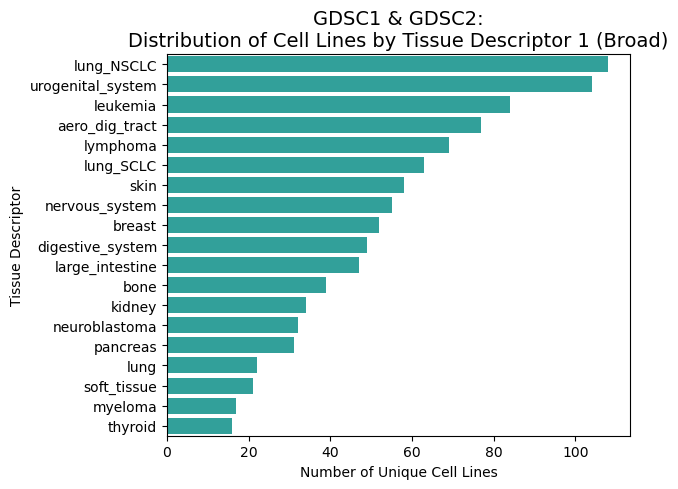

In [67]:
unique_lines = gdsc_merged[['CELL_LINE_NAME', 'GDSC_Tissue_descriptor_1']].drop_duplicates()

plt.figure(figsize=(6.5, 5))
sns.countplot(data=unique_lines, y='GDSC_Tissue_descriptor_1',
              order=unique_lines['GDSC_Tissue_descriptor_1'].value_counts().index,
              color="lightseagreen")

plt.title('GDSC1 & GDSC2:\nDistribution of Cell Lines by Tissue Descriptor 1 (Broad)', fontsize=14)
plt.xlabel('Number of Unique Cell Lines')
plt.ylabel('Tissue Descriptor')
plt.tight_layout()
# plt.savefig("GDSC_merged_Tissue_Descriptor1_broad.png", dpi=300)
plt.show()

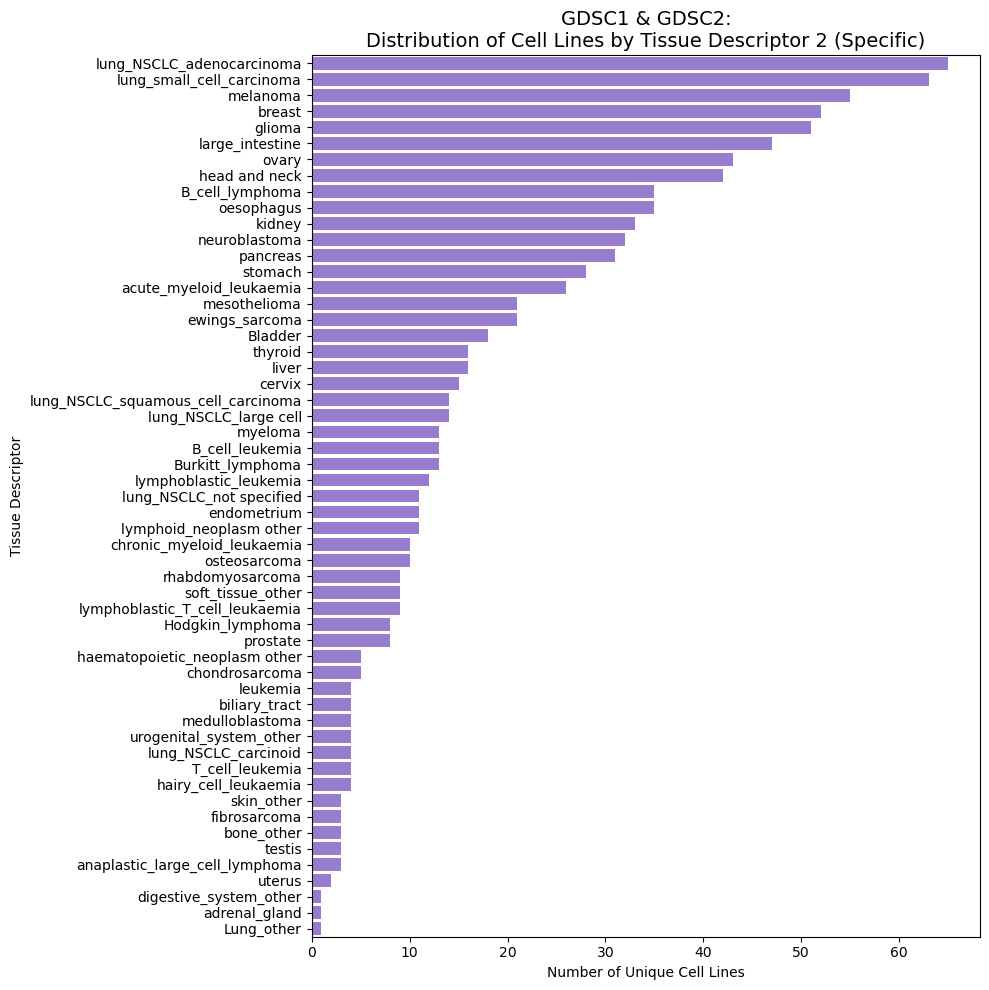

In [68]:
# unique_targets = gdsc_merged[['PUTATIVE_TARGET', 'GDSC_Tissue_descriptor_2']].drop_duplicates()
unique_lines = gdsc_merged[['CELL_LINE_NAME', 'GDSC_Tissue_descriptor_2']].drop_duplicates()

plt.figure(figsize=(10, 10))
sns.countplot(data=unique_lines, y='GDSC_Tissue_descriptor_2', 
              order=unique_lines['GDSC_Tissue_descriptor_2'].value_counts().index,
              color="mediumpurple")

plt.title('GDSC1 & GDSC2:\nDistribution of Cell Lines by Tissue Descriptor 2 (Specific)', fontsize=14)
plt.xlabel('Number of Unique Cell Lines')
plt.ylabel('Tissue Descriptor')
plt.tight_layout()
# plt.savefig("GDSC_merged_Tissue_Descriptor2_narrow.png", dpi=300)
plt.show()

There's overlap within each Tissue Descriptor from the appended cell line meta deta. Within Tissue Descriptor 1, lung, lung_NSCLC, and lung_SCLC. They indicate generic lung cancer, non-small cell lung cancer subtype and small cell subtype. They overlap in terms of biology but differences may signficantly impact modeling. In the literature, I've not seen anyone try to combine them.

## Top Drugs
View the top 30 drugs by number of observations

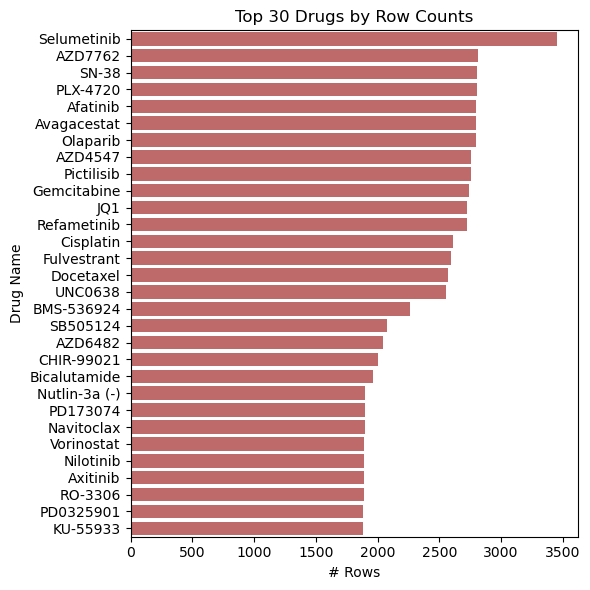

In [71]:
drug_order = gdsc_merged["DRUG_NAME"].value_counts().head(30).index

plt.figure(figsize=(6, 6))
sns.countplot(data=gdsc_merged[gdsc_merged["DRUG_NAME"].isin(drug_order)],
              y="DRUG_NAME",
              order=drug_order,
              color="indianred")
plt.title(f"Top {len(drug_order)} Drugs by Row Counts")
plt.xlabel("# Rows")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

## Top Drug Targets
View the top 30 drugs by number of observations

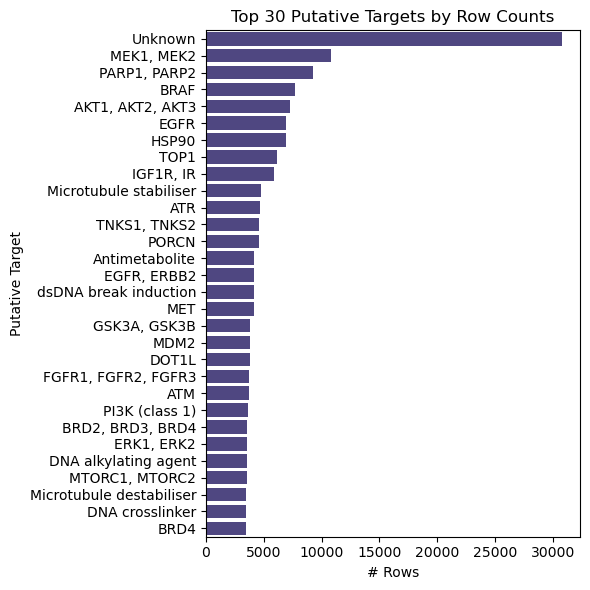

In [73]:
gdsc_merged["PUTATIVE_TARGET"] = gdsc_merged["PUTATIVE_TARGET"].fillna("Unknown") # 30807 unknown targets
tgt_order = gdsc_merged["PUTATIVE_TARGET"].value_counts().head(30).index

plt.figure(figsize=(6, 6))
sns.countplot(data=gdsc_merged[gdsc_merged["PUTATIVE_TARGET"].isin(tgt_order)],
              y="PUTATIVE_TARGET",
              order=tgt_order,
              color="darkslateblue")
plt.title(f"Top {len(tgt_order)} Putative Targets by Row Counts")
plt.xlabel("# Rows")
plt.ylabel("Putative Target")
plt.tight_layout()
plt.show()

It's very striking that most drugs have unknown targets.

### Compare the empirical distribution of both endpoints (LN_IC50 vs AUC) across the most common putative targets 

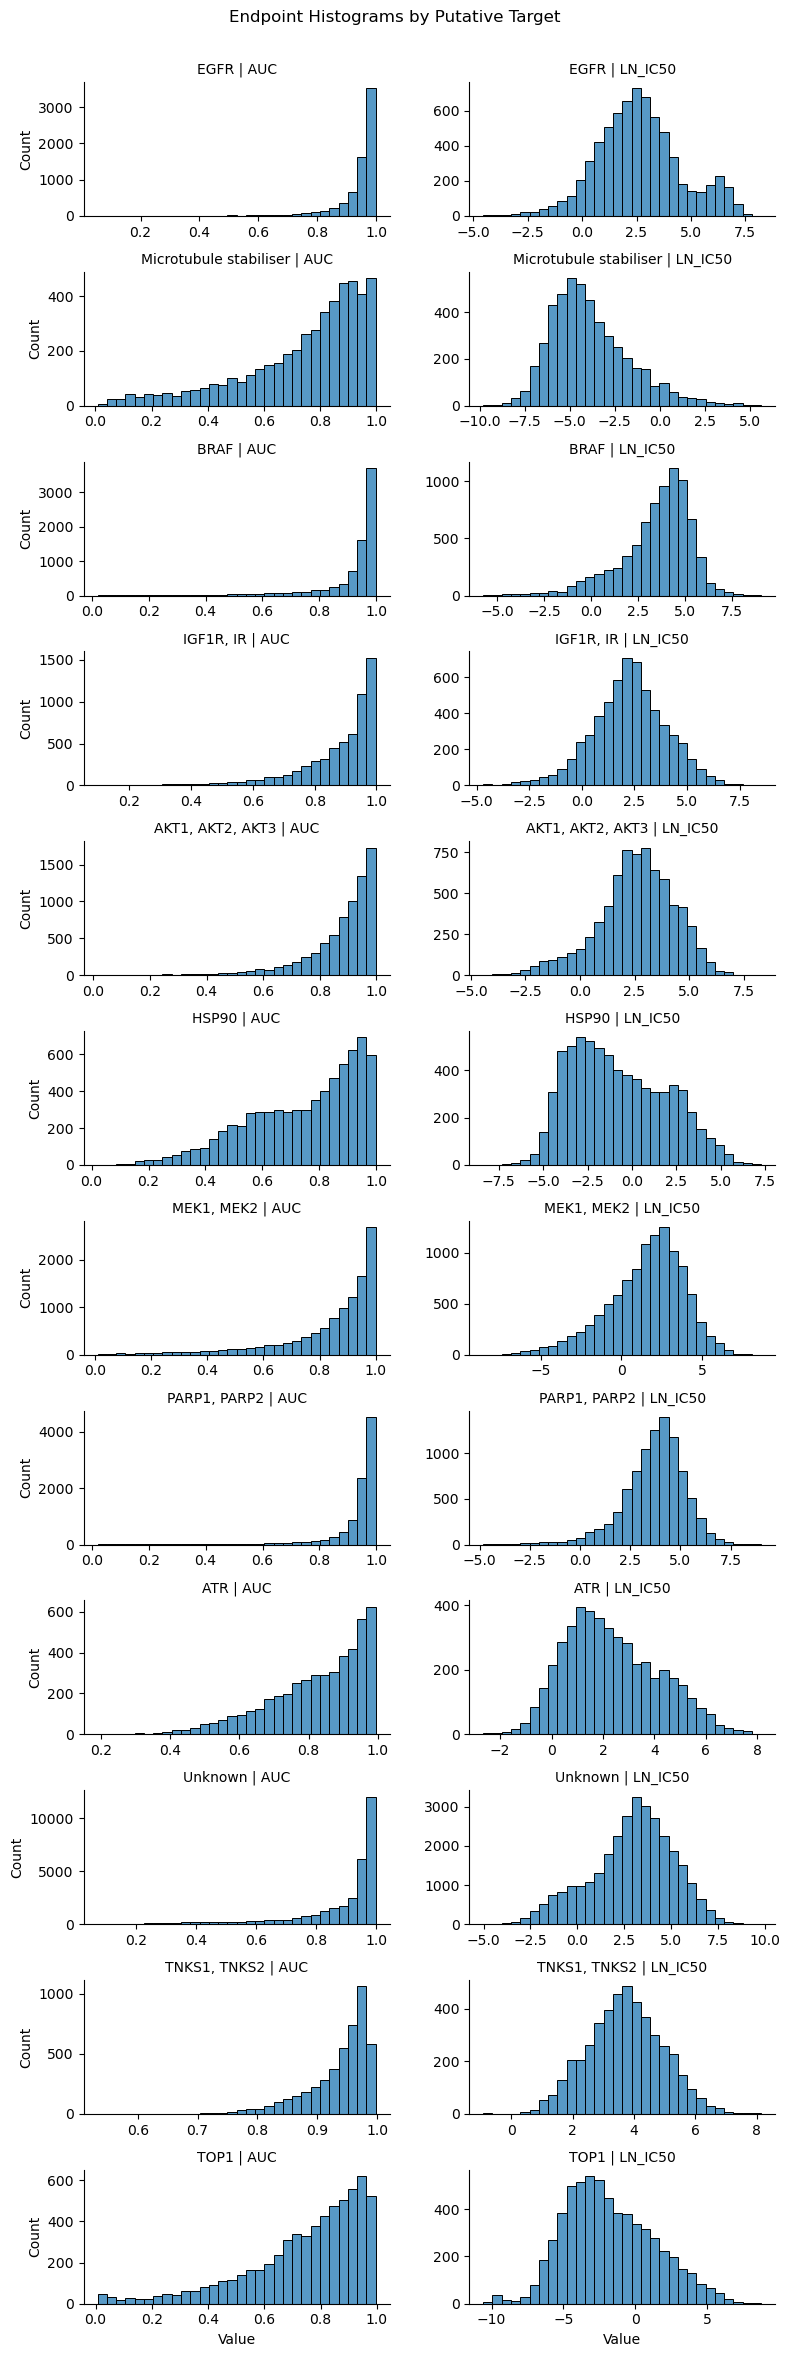

In [76]:
top_tgts = (gdsc_merged["PUTATIVE_TARGET"].value_counts().head(12).index)
sub = gdsc_merged[gdsc_merged["PUTATIVE_TARGET"].isin(top_tgts)][["PUTATIVE_TARGET", "AUC", "LN_IC50"]]

long = sub.melt(id_vars="PUTATIVE_TARGET",
                value_vars=["AUC","LN_IC50"],
                var_name="endpoint", value_name="value")

g = sns.FacetGrid(long, col="endpoint", row="PUTATIVE_TARGET",
                  sharex=False, sharey=False, height=2.0, aspect=2.0)

g.map(sns.histplot, "value", bins=30, kde=False)
g.set_axis_labels("Value", "Count")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Endpoint Histograms by Putative Target")
plt.show()

## Histograms of LN_IC50, AUC, RMSE and Z_SCORE by Dataset
We know that GDSC1 has a larger number of experiments, with viability assay data from 345 screened drugs, wheraas GDSC2 was initated later and attempted to standardize experimental design and quality. Since we combine both to have more observations, drugs, and targets, we hope the models will generalize better to unseen data

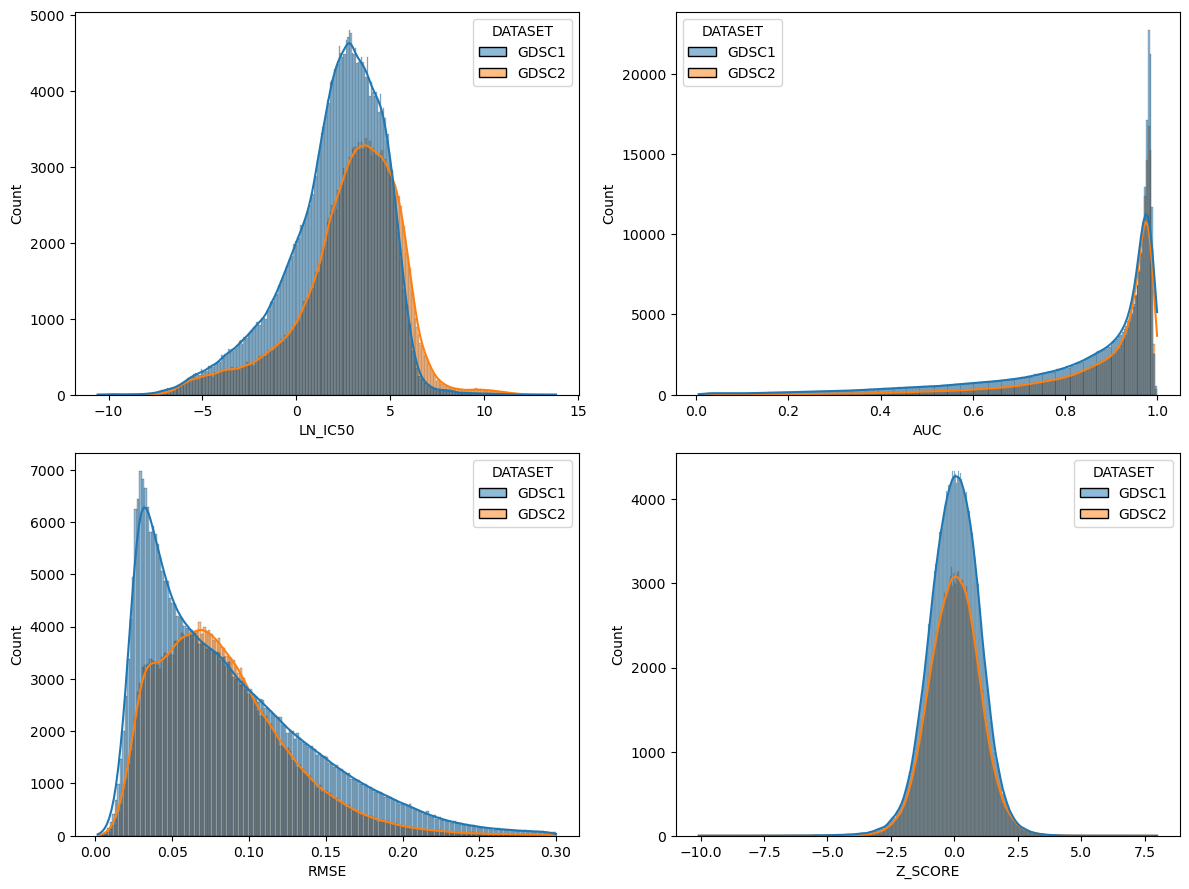

In [78]:
fig, axes = plt.subplots(2,2, figsize=(12,9))
sns.histplot(data=gdsc_merged, x="LN_IC50", hue="DATASET", kde=True, ax=axes[0,0])
sns.histplot(data=gdsc_merged, x="AUC", hue="DATASET", kde=True, ax=axes[0,1])
sns.histplot(data=gdsc_merged, x="RMSE", hue="DATASET", kde=True, ax=axes[1,0])
sns.histplot(data=gdsc_merged, x="Z_SCORE", hue="DATASET", kde=True, ax=axes[1,1])
plt.tight_layout()

## Correlation Matrix

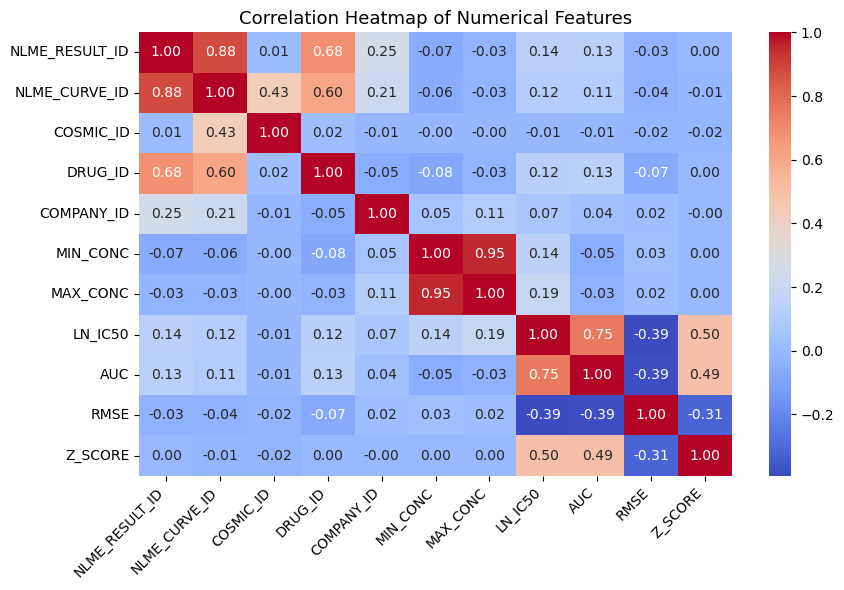

In [81]:
corr = gdsc_merged.select_dtypes(include=['float64','int64']).corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()
plt.show()

* Consistent with the GDSC papers, AUC here is "viability area" or area under the viability curve (instead of killing curve)
* So generally, when LC_IC50 is higher (more resistant), AUC is also higher. Low AUC and low LN_IC50 = sensitive

## Censoring and QC Flags
Flag rows where the fitted dose-response probably hit bounds or had a poor fit, indicated by RMSE. We don't need to necessarily filter these out, but we may want to handle them more carefully in downstream sensitivity analysis and modeling

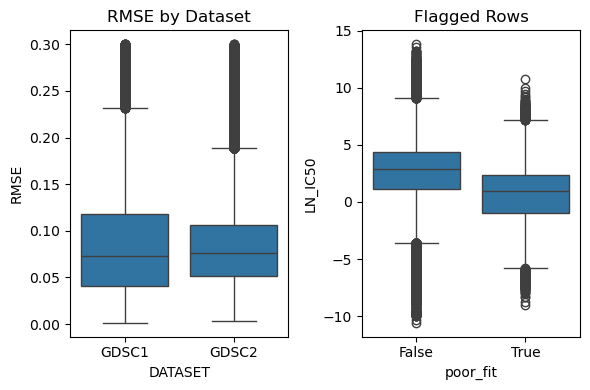

In [84]:
gdsc_merged["at_min_dose"] = np.isclose(gdsc_merged["LN_IC50"], gdsc_merged["MIN_CONC"], atol=1e-6) if "LN_IC50" in gdsc_merged else False
gdsc_merged["at_max_dose"] = np.isclose(gdsc_merged["LN_IC50"], gdsc_merged["MAX_CONC"], atol=1e-6) if "LN_IC50" in gdsc_merged else False

rmse_thr = gdsc_merged["RMSE"].quantile(0.95) if gdsc_merged["RMSE"].notna().any() else None
gdsc_merged["poor_fit"] = gdsc_merged["RMSE"] > rmse_thr if rmse_thr is not None else False
qc_cols = ["at_min_dose","at_max_dose","poor_fit"]
gdsc_merged[qc_cols].mean()

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
sns.boxplot(data=gdsc_merged, x="DATASET", y="RMSE", ax=axes[0])
axes[0].set_title("RMSE by Dataset")

sns.boxplot(data=gdsc_merged, x="poor_fit", y="LN_IC50", ax=axes[1])
axes[1].set_title("Flagged Rows")

plt.tight_layout()
plt.show()

In [85]:
n_bad = gdsc_merged["poor_fit"].sum()
pct_bad = gdsc_merged["poor_fit"].mean()*100
print(f"{n_bad} rows flagged ({pct_bad:.2f}%)")

28759 rows flagged (5.00%)


## Check for Confounding Categorical Variables
Plotted separately per endpoint

In [87]:
cat_cols = ["DATASET", "GDSC_Tissue_descriptor_1", "Cancer_Type_TCGA", "Medium", "Growth"]

for c in cat_cols:
    if c in gdsc_merged.columns:
        g = gdsc_merged.groupby(c)["LN_IC50"].median().sort_values()
        # print(f"\nMedian LN_IC50 by {c} (top 10):")
        # display(g.head(10))
        # display(g.tail(10))

### LN_IC50 plots by potential confounding variables

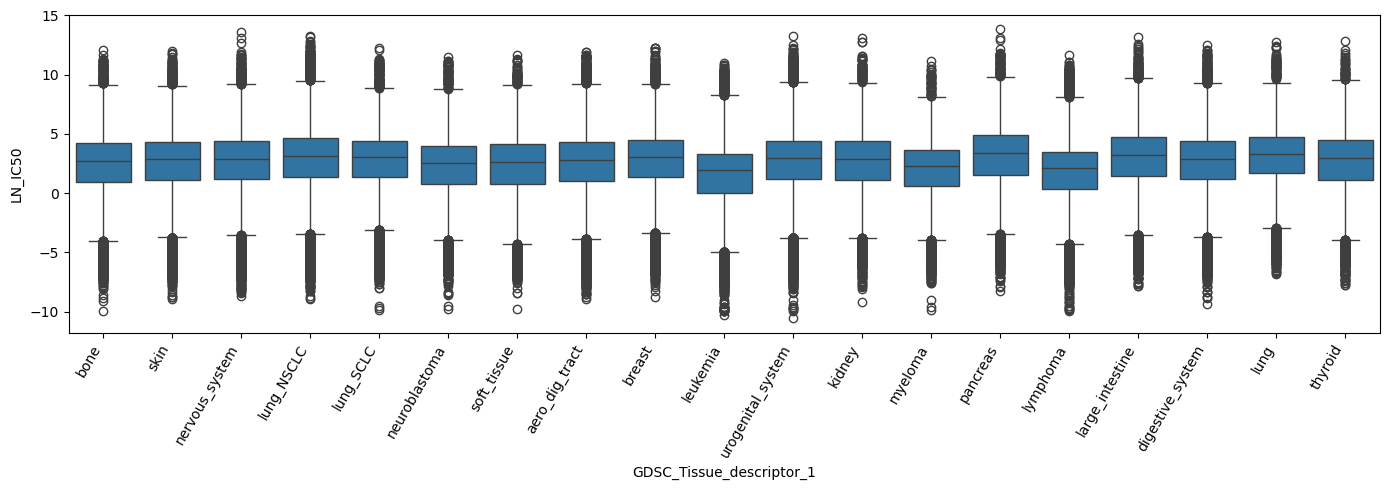

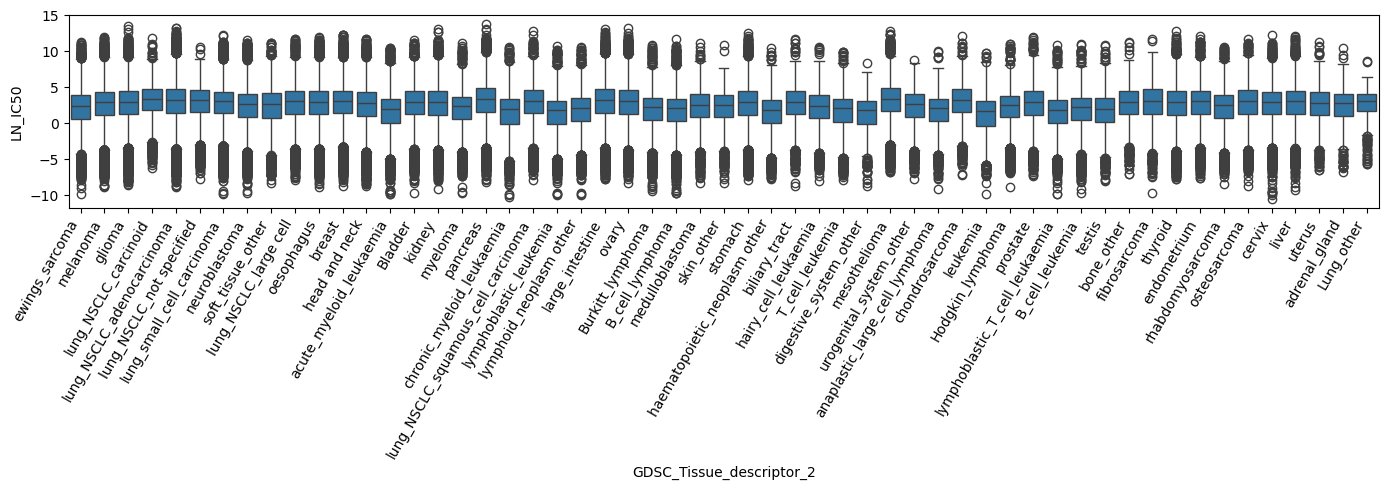

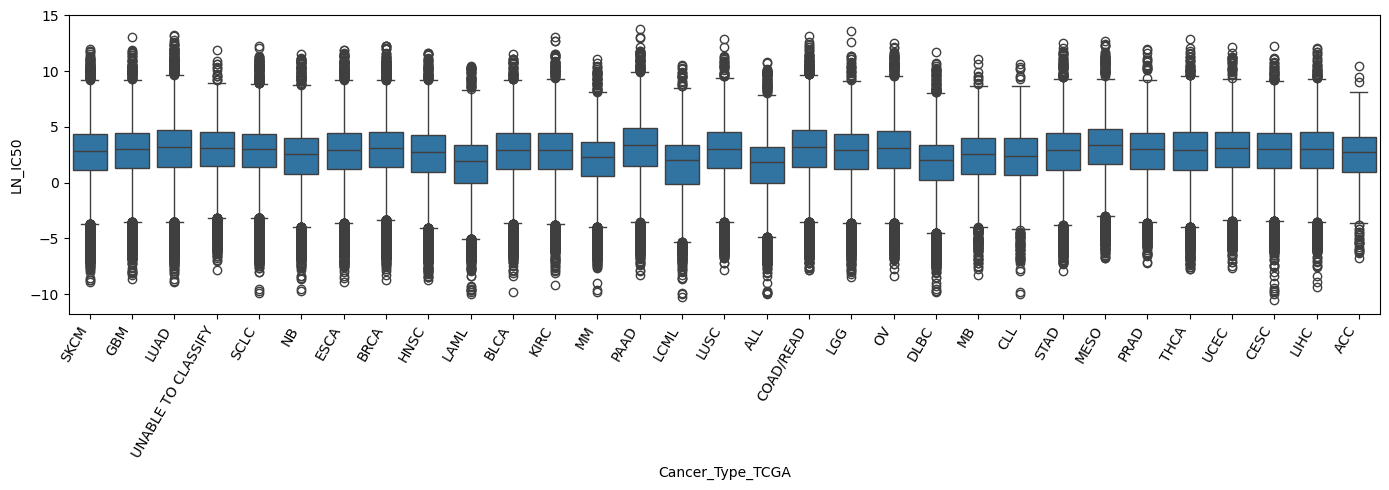

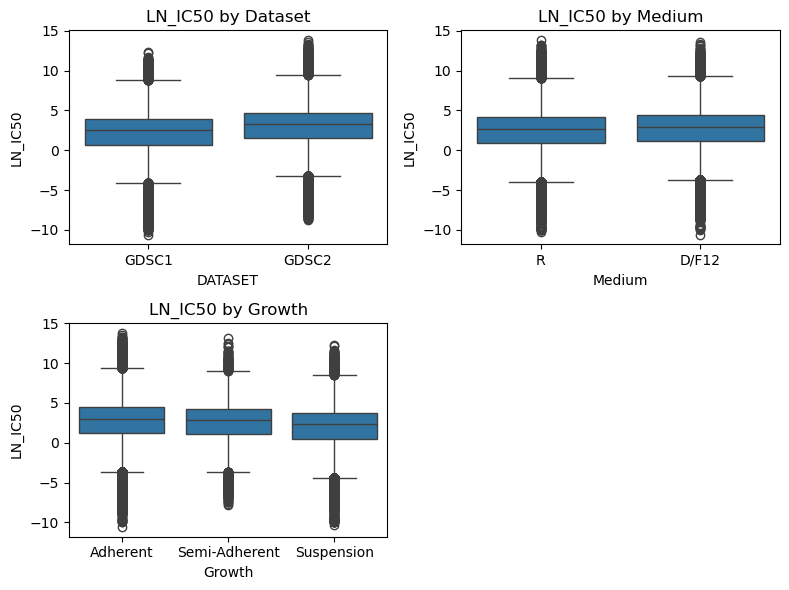

In [89]:
plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="GDSC_Tissue_descriptor_1", y="LN_IC50")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="GDSC_Tissue_descriptor_2", y="LN_IC50")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="Cancer_Type_TCGA", y="LN_IC50")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8,6))
sns.boxplot(data=gdsc_merged, x="DATASET", y="LN_IC50", ax=axes[0,0])
axes[0,0].set_title("LN_IC50 by Dataset")

sns.boxplot(data=gdsc_merged, x="Medium", y="LN_IC50", ax=axes[0,1])
axes[0,1].set_title("LN_IC50 by Medium")

sns.boxplot(data=gdsc_merged, x="Growth", y="LN_IC50", ax=axes[1,0])
axes[1,0].set_title("LN_IC50 by Growth")

axes[1,1].axis("off")
plt.tight_layout()
plt.show()

###  AUC plots by potential confounding variables

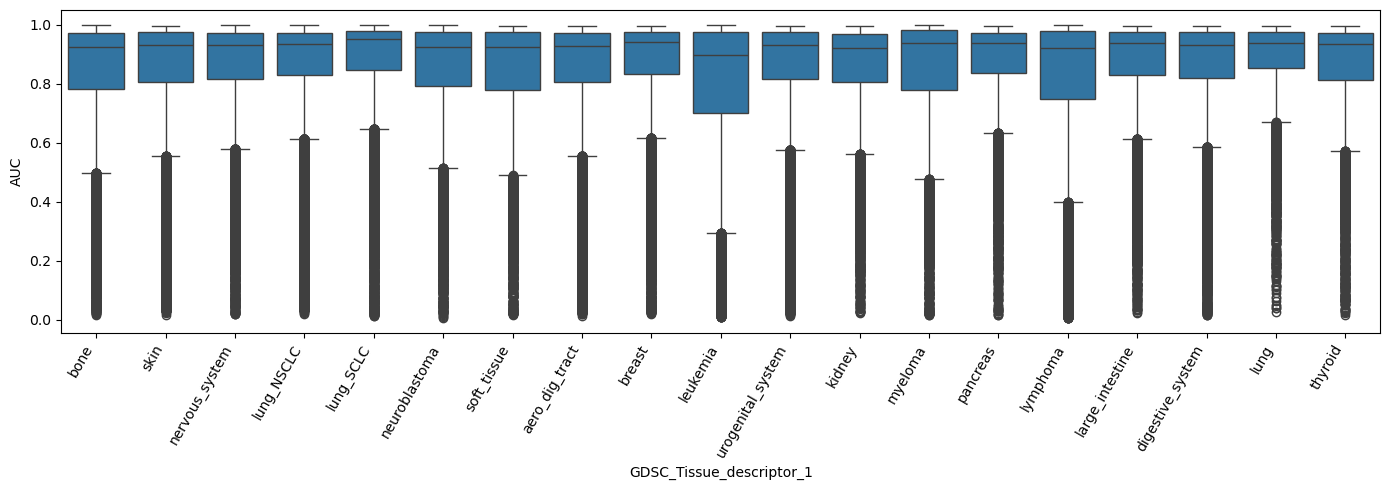

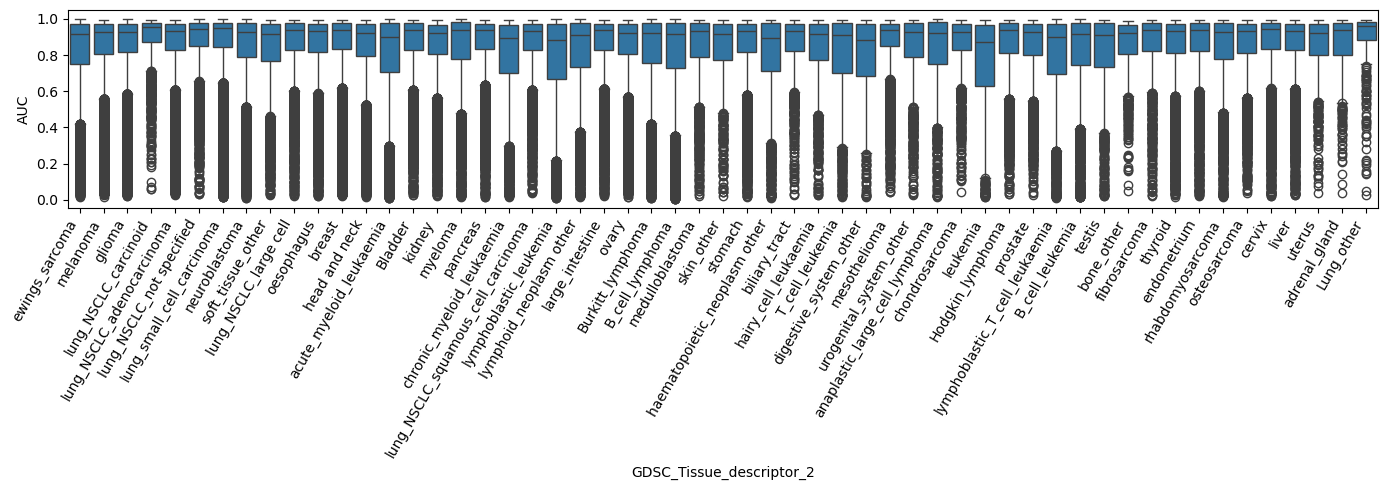

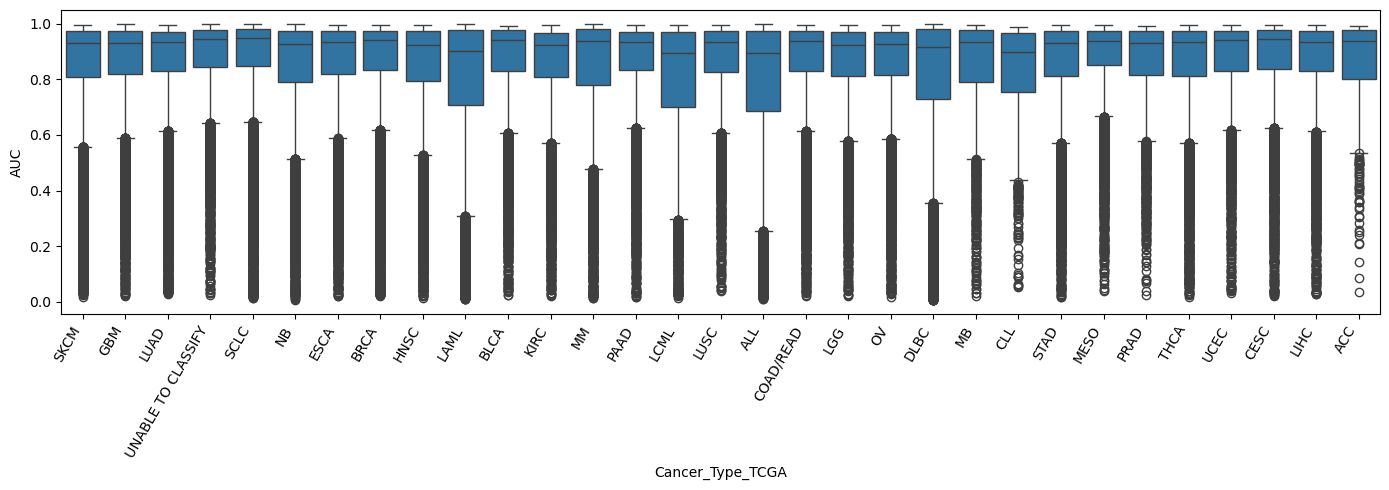

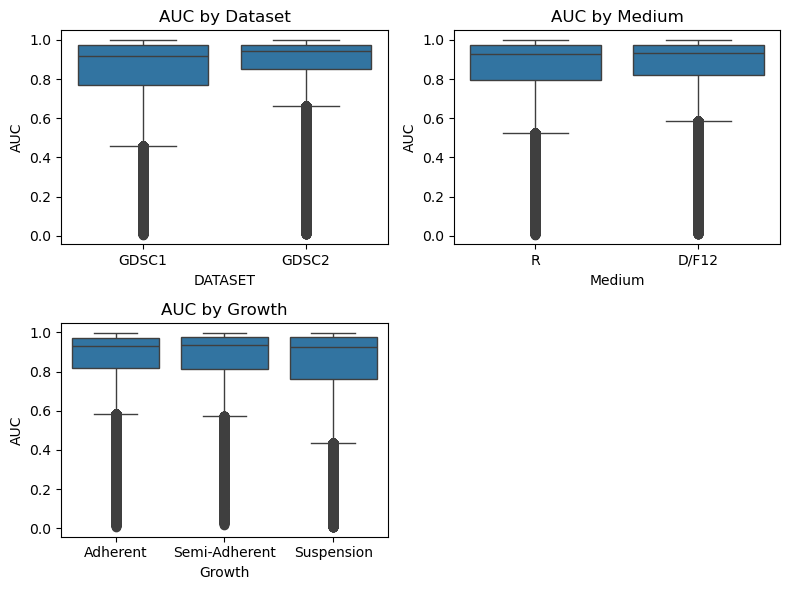

In [91]:
plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="GDSC_Tissue_descriptor_1", y="AUC")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="GDSC_Tissue_descriptor_2", y="AUC")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(data=gdsc_merged, x="Cancer_Type_TCGA", y="AUC")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()


fig, axes = plt.subplots(2, 2, figsize=(8,6))
sns.boxplot(data=gdsc_merged, x="DATASET", y="AUC", ax=axes[0,0])
axes[0,0].set_title("AUC by Dataset")

sns.boxplot(data=gdsc_merged, x="Medium", y="AUC", ax=axes[0,1])
axes[0,1].set_title("AUC by Medium")

sns.boxplot(data=gdsc_merged, x="Growth", y="AUC", ax=axes[1,0])
axes[1,0].set_title("AUC by Growth")

axes[1,1].axis("off")
plt.tight_layout()
plt.show()

There are some large shifts in AUC plots, but features such as growth media and culture format surpisingly similar.
Consider stratifying splits by tissue or include as covariates. Possibly linear mixed effects for modeling fairness later.

## Expanded QC
* LN_IC50 vs AUC Spearman correlation
* rank agreement across tissues
* divergence by tissue
* drug-level concordance tests

Collapse replicate-level rows into a single canonical row per (drug, cell) pair, taking medians of numeric endpoints and attaching stable metadata

In [95]:
df = gdsc_merged.copy()
mask = df["LN_IC50"].notna() & df["AUC"].notna()
rmse_thr = df["RMSE"].quantile(0.95) 
mask &= df["RMSE"] <= rmse_thr

dfq = df.loc[mask].copy()
group_keys = ["DRUG_ID", "DRUG_NAME", "COSMIC_ID", "CELL_LINE_NAME"]
num_cols = dfq.select_dtypes(include=[np.number]).columns.tolist()
num_agg = {c: "median" for c in num_cols} # LN_IC50 & AUC included

cat_cols = ["DATASET", "GDSC_Tissue_descriptor_1", "GDSC_Tissue_descriptor_2",
            "Cancer_Type_TCGA", "Medium", "Growth", "PUTATIVE_TARGET", "PATHWAY_NAME"]
cat_cols = [c for c in cat_cols if c in dfq.columns]
cat_agg = {c: "first" for c in cat_cols} 

Xy = (dfq.groupby(group_keys, as_index=False)
      .agg({**num_agg, **cat_agg}))

## LN_IC50 vs AUC relationship

### Hexbin plot and broader relationship (Pearson)

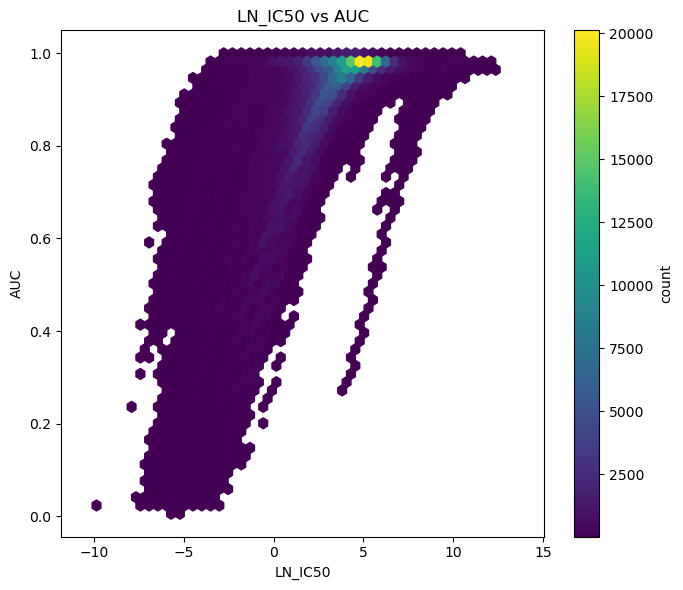

Spearman rho (overall): 0.7498  p=0.00e+00
GDSC1: rho=0.7541  p=0.00e+00
GDSC2: rho=0.7334  p=0.00e+00


In [98]:
plt.figure(figsize=(7,6))
hb = plt.hexbin(Xy["LN_IC50"], Xy["AUC"], gridsize=50, mincnt=10)
plt.colorbar(hb, label="count")
plt.xlabel("LN_IC50"); plt.ylabel("AUC"); plt.title("LN_IC50 vs AUC")
plt.tight_layout(); plt.show()

# Correlations
rho_all, p_all = spearmanr(Xy["LN_IC50"], Xy["AUC"]) 
print(f"Spearman rho (overall): {rho_all:.4f}  p={p_all:.2e}")

for ds, subdf in Xy.groupby("DATASET"):
    r, p = spearmanr(subdf["LN_IC50"], subdf["AUC"]) 
    print(f"{ds}: rho={r:.4f}  p={p:.2e}")

Strong, positive monotonic trend since both LN_IC50 and AUC track resistance. There appears to be a heavy upper band near AUC=1. This may suggest that many curves show little to no viability loss, meaning weakly effective drugs and drug-resistant cell lines dominate.

LN_IC50 also has a long left tail, indicating highly sensitive case, but the counts are much lower (<= 1000 per hex)

### Higher resolution: Per-drug paired ranking shift across tissues
We know that overall and by dataset, AUC and LN_IC50 are fairly concordant. 
For each drug, we now compare how tissues rank under both endpoints. Do we get the same ordering when ranking sensitivity using LC_IC50 and AUC?

Top 10 most discordant:
      DRUG_ID          DRUG_NAME  n_tissues  spearman_r             p
494   1784.0            LMB_AB2       19.0   -0.878947  7.301515e-07
487   1776.0        GSK2256098C       19.0   -0.878947  7.301515e-07
508   1814.0         Nelarabine       19.0   -0.847368  4.681088e-06
448   1585.0       BDF00022089a       19.0   -0.833333  9.401481e-06
522   1831.0  L-Oxonoreleagnine       19.0   -0.789474  5.838692e-05
464   1627.0             GSK343       19.0   -0.789474  5.838692e-05
490   1779.0        GSK626616AC       19.0   -0.785965  6.633366e-05
519   1828.0             720427       19.0   -0.773684  1.018640e-04
493   1783.0            LMB_AB1       19.0   -0.768421  1.214577e-04
458   1620.0               PFI3       19.0   -0.757895  1.704261e-04

Top 10 most concordant:
      DRUG_ID     DRUG_NAME  n_tissues  spearman_r             p
412   1460.0     PARP_9482       19.0    0.998246  2.579847e-22
163    328.0      SNX-2112       19.0    0.998246  2.579847e-2

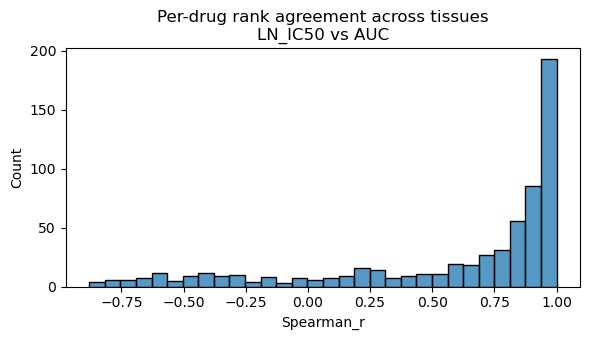

In [101]:
tissue = "GDSC_Tissue_descriptor_1" # broader
# tissue = "GDSC_Tissue_descriptor_2" # finer 

dt = (Xy.groupby(["DRUG_ID","DRUG_NAME", tissue])
        [["LN_IC50","AUC"]].median().reset_index())

def _rank_agreement(g):
    '''Calc per-drug rank agreement across tissues'''
    r_ic50 = g["LN_IC50"].rank(method="average")
    r_auc = g["AUC"].rank(method="average")
    r, p = spearmanr(r_ic50, r_auc)
    return pd.Series({"n_tissues": g[tissue].nunique(),
                      "spearman_r": r,
                      "p": p})

rank_shift = (dt.groupby(["DRUG_ID","DRUG_NAME"])[["LN_IC50", "AUC", tissue]]
                .apply(_rank_agreement)
                .reset_index()
                .sort_values("spearman_r"))

print("Top 10 most discordant:\n", rank_shift.head(10)) 
print("\nTop 10 most concordant:\n", rank_shift.tail(10))

plt.figure(figsize=(6, 3.5))
sns.histplot(rank_shift["spearman_r"], bins=30, kde=False)
plt.xlabel("Spearman_r")
plt.title("Per-drug rank agreement across tissues\nLN_IC50 vs AUC")
plt.tight_layout()
plt.show()

### Zooming in a bit, let's look at a facet plot of these discordant drugs to see the relationship between both endpoints

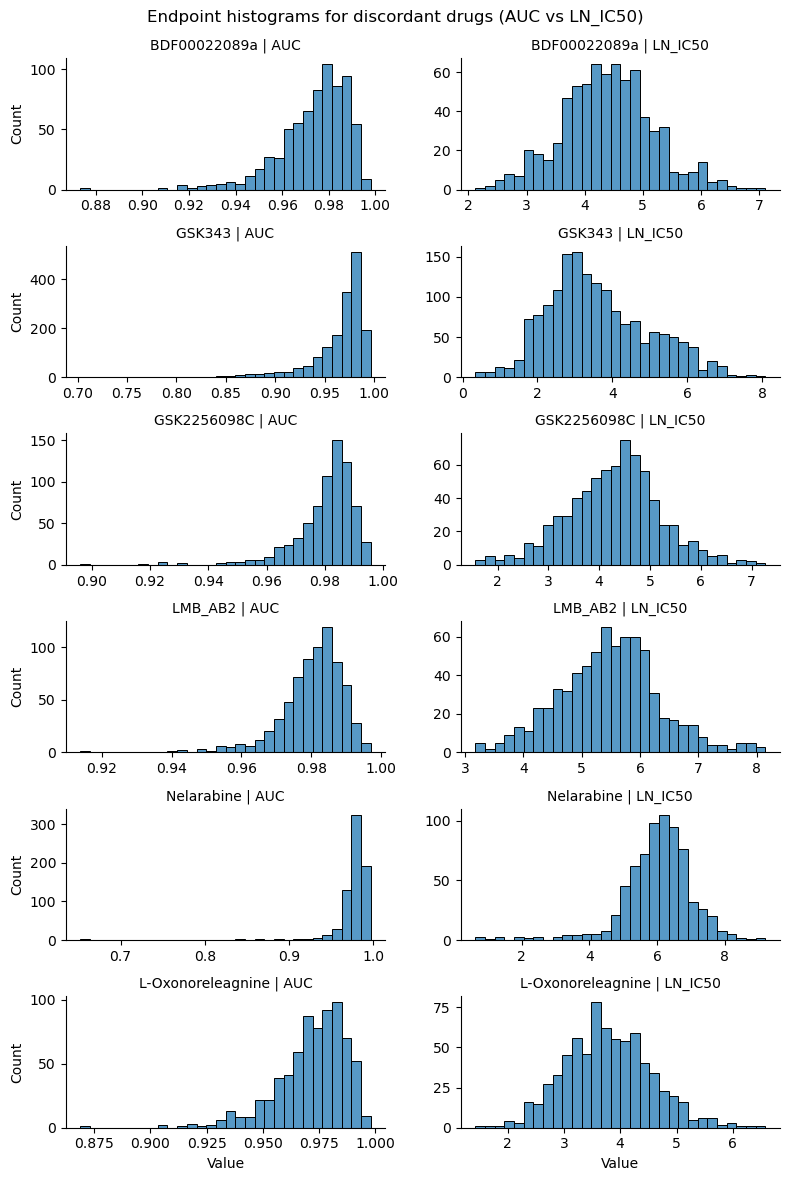

In [103]:
# Facet plot by DRUG_NAME and endpoints
discordant = rank_shift.sort_values("spearman_r").head(6)["DRUG_NAME"].tolist()

base = Xy.copy()
focus = base[base["DRUG_NAME"].isin(discordant)].copy()

long = focus.melt(id_vars=["DRUG_NAME"],
                  value_vars=["AUC","LN_IC50"],
                  var_name="endpoint", value_name="value")

g = sns.FacetGrid(long, row="DRUG_NAME", col="endpoint", 
                  sharex=False, sharey=False, height=2.0, aspect=2.0)

g.map(sns.histplot, "value", bins=30, kde=False)
g.set_axis_labels("Value", "Count")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
plt.subplots_adjust(top=0.94)
g.fig.suptitle("Endpoint histograms for discordant drugs (AUC vs LN_IC50)")
plt.show()

### Zooming in to a single discordant drug, let's compare endpoints distributions by tissue types

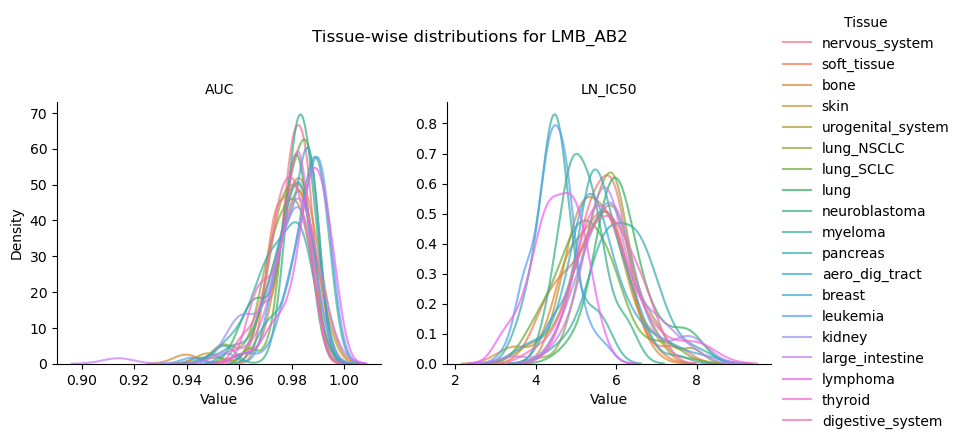

In [105]:
# pick one drug to drill into
drug_name = discordant[0] 

dr = base[base["DRUG_NAME"] == drug_name].copy()
tissue_col = "GDSC_Tissue_descriptor_1" # broad descriptor

long = dr.melt(id_vars=[tissue_col], value_vars=["AUC","LN_IC50"],
               var_name="endpoint", value_name="value")

g = sns.FacetGrid(long, col="endpoint", hue=tissue_col,
                  sharex=False, sharey=False, height=4.0, aspect=1.0)

g.map_dataframe(sns.kdeplot, x="value", common_norm=False, alpha=0.7)

g.add_legend(title="Tissue")
g.set_axis_labels("Value", "Density")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.80)
g.fig.suptitle(f"Tissue-wise distributions for {drug_name}")
plt.show()

## Per-tissue endpoint divergence (delta vs global medians)

Where do tissues flip depending on endpoint used? Need to know this before stratifying and modeling.

Tissues at the extremes are where endpoint choice most affects conclusions and later model evaluation; flag these for scrutiny

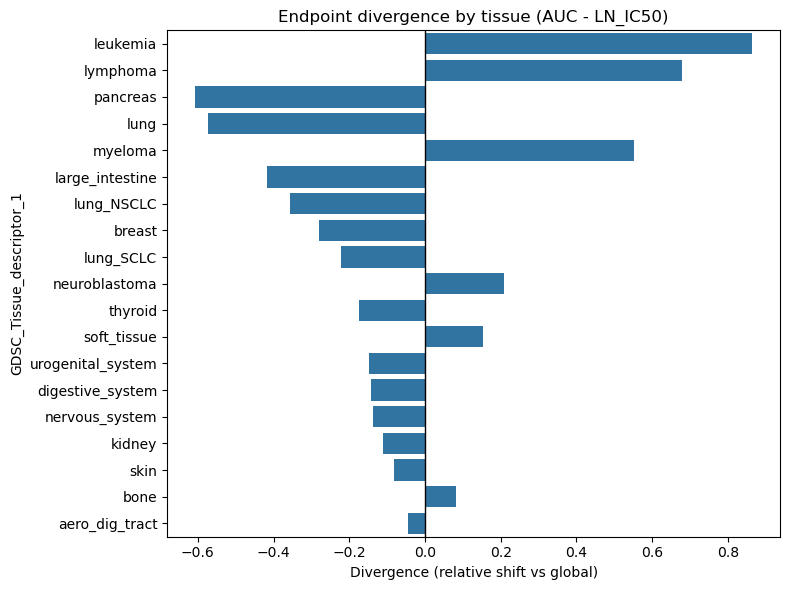

,GDSC_Tissue_descriptor_1,n,delta_ln,delta_auc,divergence
6,leukemia,42926,-0.894606,-0.030707,0.863899
10,lymphoma,35099,-0.690492,-0.010603,0.679889
14,pancreas,15986,0.611414,0.003977,-0.607437
7,lung,11306,0.579960,0.007548,-0.572413
11,myeloma,8908,-0.549048,0.003049,0.552097
5,large_intestine,24382,0.424829,0.006999,-0.417830
8,lung_NSCLC,55497,0.361078,0.003769,-0.357309
2,breast,26682,0.289048,0.008598,-0.280450
9,lung_SCLC,29078,0.239557,0.017041,-0.222517
13,neuroblastoma,15864,-0.212280,-0.003598,0.208682


In [107]:
# Global and per-tissue medians
overall_ln  = Xy["LN_IC50"].median()
overall_auc = Xy["AUC"].median()
t1 = (Xy.groupby(tissue)
        .agg(med_ln=("LN_IC50","median"),
             med_auc=("AUC","median"),
             n=("LN_IC50","size"))
        .reset_index())

# shift relative to global
t1["delta_ln"]  = t1["med_ln"] - overall_ln
t1["delta_auc"] = t1["med_auc"] - overall_auc
t1["divergence"] = t1["delta_auc"] - t1["delta_ln"] 

tplot = t1.reindex(t1["divergence"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 6))
sns.barplot(data=tplot, y=tissue, x="divergence")
plt.axvline(0, color="k", lw=1)
plt.title("Endpoint divergence by tissue (AUC - LN_IC50)")
plt.xlabel("Divergence (relative shift vs global)")
plt.tight_layout()
plt.show()

tplot[["GDSC_Tissue_descriptor_1", "n", "delta_ln", "delta_auc", "divergence"]]

When divergence is greater than 0, the tissue more resistant per the AUC endpoint than LN_IC50. We may need to carefully handle these, possibly by inverting AUC.

## Compare GDSC_Tissue_descriptor_1 and GDSC_Tissue_descriptor_2
One last dive into both tissue types to inform splitting

#### Tissue descriptor 1

In [111]:
overall_median = gdsc_merged["LN_IC50"].median()
tissue_shift_1 = (gdsc_merged.groupby("GDSC_Tissue_descriptor_1")["LN_IC50"]
                  .median().sort_values().to_frame("median_ln_ic50"))
tissue_shift_1["delta_vs_overall"] = tissue_shift_1["median_ln_ic50"] - overall_median
tissue_shift_1

,median_ln_ic50,delta_vs_overall
GDSC_Tissue_descriptor_1,,
leukemia,1.918349,-0.869049
lymphoma,2.112534,-0.674864
myeloma,2.292155,-0.495243
neuroblastoma,2.568802,-0.218596
soft_tissue,2.619029,-0.168369
bone,2.694126,-0.093272
aero_dig_tract,2.823221,0.035823
skin,2.842077,0.054679
kidney,2.878891,0.091493


### tissue_shift_1
* broader categories (leukemia, lymphoma, pancreas, etc)
* fewer bins = more n's per bin = stable medians
* captures broad pharmacodynamic variance - could be implemented into baselines models

#### Tissue descriptor 2

In [114]:
tissue_shift_2 = (gdsc_merged.groupby("GDSC_Tissue_descriptor_2")["LN_IC50"]
                  .median().sort_values().to_frame("median_ln_ic50"))
tissue_shift_2["delta_vs_overall"] = tissue_shift_2["median_ln_ic50"] - overall_median
tissue_shift_2

,median_ln_ic50,delta_vs_overall
GDSC_Tissue_descriptor_2,,
leukemia,1.634103,-1.153295
digestive_system_other,1.743677,-1.043721
lymphoblastic_leukemia,1.752514,-1.034884
haematopoietic_neoplasm other,1.800915,-0.986483
lymphoblastic_T_cell_leukaemia,1.845800,-0.941598
acute_myeloid_leukaemia,1.896810,-0.890588
chronic_myeloid_leukaemia,1.982988,-0.804410
testis,2.005279,-0.782119
B_cell_lymphoma,2.023958,-0.763440


### tissue_shift_2
* more granular categories (Burkitt_lymphoma, rhabdomyosarcoma, AML, etc)
* stratifying by these bins may be impossible due to low sample size ->unstable medians
* models may fit to rarer subtypes, however we could apply resampling (sklearn.utils) to balance distribution of rarer categories